<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%EC%97%AC%EC%A7%84%EC%98%81/%EC%82%BC%EC%84%B1_%EC%8B%A4%EC%8A%B5_3%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/삼성_실습_3일차

In [ ]:
!pip install -q datasets
!pip install torch transformers pandas

# 1) BERT vs GPT-2

#### 1-1) BPE 구현하기

```
# vocabulary
low, lower, newest, widest
```

초기 Vocabulary (Character 단위로 분리)
```
# vocabulary
l, o, w, e, r, n, s, t, i, d
```

가장 빈도수가 높은 'e, s'를 es로 통합하고 단어장 업데이트
```
# vocabulary update!
l, o, w, e, r, n, s, t, i, d, es
```

가장 빈도수가 높은 'es, t'를 est로 통합하고 단어장 업데이
```
# vocabulary update!
l, o, w, e, r, n, s, t, i, d, es, est
```
...

최종 Vocabulary (반복 횟수는 사용자가 설정)
```
# vocabulary update!
l, o, w, e, r, n, s, t, i, d, es, est, lo, low, ne, new, newest, wi, wid, widest
```






* BPE 알고리즘 실습

In [ ]:
import re, collections
from IPython.display import display, Markdown, Latex

In [ ]:
num_merges = 10

In [ ]:
dictionary = {'l o w </w>' : 5,
         'l o w e r </w>' : 2,
         'n e w e s t </w>': 6,
         'w i d e s t </w>': 3
         }

In [ ]:
def get_stats(dictionary):
    # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

bpe_codes = {}
bpe_codes_reverse = {}

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

* GPT Tokenizer 구현하기

In [ ]:
corpus = [
    "This is the Hugging Face course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

* 위 말뭉치를 단어 단위로 사전 토큰화(pre-tokenize)
* GPT-2 Tokenizer를 구현하고 있으므로, 사전 토큰화도 gpt2 활용

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

* 각 단어의 빈도 수 계산

In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

* 말뭉치에 사용된 모든 문자로 구성된 기본 vocabulary 구성

In [ ]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

- <|endoftext|>는 vocab의 시작을 알리는 special token

In [ ]:
vocab = ["<|endoftext|>"] + alphabet.copy()

In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}
print(splits)

- 각 바이트 페어의 빈도를 계산하는 함수

In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i+1])
            pair_freqs[pair] += freq
    return pair_freqs

- 바이트 페어를 merge하는 함수

In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

- 50개의 vocab이 만들어 질 때까지 반복

In [ ]:
vocab_size = 50
merges = {}
while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [ ]:
print(vocab)

- 새로운 텍스트 토큰화하기

In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

In [ ]:
tokenize("This is not a token.")

#### 1-2) BERT vs GPT tokenizer
- GPT는 character 단위로 단어를 분해하므로 special token이 없다(" 제외)

In [ ]:
from transformers import GPT2Tokenizer, BertTokenizer

gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

prompt = "GPT2 is a model developed by OpenAI."

print("============= GPT =============")
input_ids = gpt_tokenizer(prompt, return_tensors="pt").input_ids
print(input_ids)
print(gpt_tokenizer.decode(input_ids[0]))

print("\n============= BERT =============")
input_ids = bert_tokenizer(prompt, return_tensors="pt").input_ids
print(input_ids)
print(bert_tokenizer.decode(input_ids[0]))


#### 1-3) BERT vs GPT task 성능 비교

##### Sentimental Analysis

- Sentimental Analysis dataset으로 BERT test

In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader

# SST-2 데이터셋 로드
dataset = load_dataset("glue", "sst2")

# 데이터셋의 일부분만 사용 (속도 향상을 위해)
small_test_dataset = dataset['validation'].shuffle(seed=42).select(range(500))

In [ ]:
class SST2Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# BERT 토크나이저 및 모델 로드
bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# 모델 평가 모드로 설정
bert_model.eval()

In [ ]:
# 데이터 전처리
texts = small_test_dataset['sentence']
labels = small_test_dataset['label']
encodings = bert_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# sst 데이터셋 인스턴스 생성
test_dataset_bert = SST2Dataset(encodings, labels)

# DataLoader 설정
test_loader_bert = DataLoader(test_dataset_bert, batch_size=32, shuffle=False)

In [ ]:
# 예측 수행
correct = 0
total = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for batch in test_loader_bert:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        outputs = bert_model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

bert_accuracy = correct / total
print(f"BERT Accuracy: {bert_accuracy:.2f}")

- GPT로 같은 Task test

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# GPT-2 토크나이저 및 모델 로드
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('michelecafagna26/gpt2-medium-finetuned-sst2-sentiment')
gpt2_model = GPT2ForSequenceClassification.from_pretrained('michelecafagna26/gpt2-medium-finetuned-sst2-sentiment', num_labels=2)

# GPT-2는 디폴트로 패딩 토큰이 없으므로 설정
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# 모델 평가 모드로 설정
gpt2_model.config.pad_token_id = gpt2_tokenizer.pad_token_id
gpt2_model.eval()

In [ ]:
# 데이터 전처리
texts = small_test_dataset['sentence']
labels = small_test_dataset['label']
encodings = gpt2_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
attention_mask = encodings.attention_mask
encodings['attention_mask'] = attention_mask

# sst 데이터셋 인스턴스 생성
test_dataset_gpt2 = SST2Dataset(encodings, labels)

# DataLoader 설정
test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=32, shuffle=False)

In [ ]:
# 예측 수행
correct = 0
total = 0
correct_predictions = 0
total_predictions = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for batch in test_loader_gpt2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = gpt2_model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

gpt_accuracy = correct_predictions / total_predictions
print(f"GPT Accuracy: {gpt_accuracy:.2f}")

- BERT (fine-tune) accuracy: 0.91
- GPT (no fine-tune) accuracy: 0.48
---
- BERT (fine-tune) accuracy: 0.91
- GPT (fine-tune) accuracy: 0.91

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model='distilbert/distilbert-base-uncased-finetuned-sst-2-english')
classifier("I've been waiting for a HuggingFace course my whole life.")

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model='michelecafagna26/gpt2-medium-finetuned-sst2-sentiment')
classifier("I've been waiting for a HuggingFace course my whole life.")
# negative LABEL_0

- BERT Fine-tune score : 0.95
- GPT Fine-tune score : 0.89

- 직접 여러 문장 테스트

##### Question - Answering

* BERT로 QA (beomi/kcbert-base)

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, QuestionAnsweringPipeline
import tensorflow as tf
import tqdm.notebook
import math

In [ ]:
model = ### 직접 작성 ### import한 model 명 참고
tokenizer = ### 직접 작성 ### import한 tokenizer 명 참고

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

In [ ]:
qa = ### 직접 작성 ### import한 pipeline 명칭 참고

In [ ]:
context = "직접 작성"

In [ ]:
question1 = '직접 작성'
question2 = '직접 작성'
question3 = '직접 작성'

In [ ]:
qa(question=question1, context=context)

{'score': 0.002200471702963114, 'start': 14, 'end': 20, 'answer': '배우로 연기'}

In [ ]:
qa(question=question2, context=context)

{'score': 0.0020958981476724148, 'start': 41, 'end': 50, 'answer': "'미나리'의 순자"}

In [ ]:
qa(question=question3, context=context)

{'score': 0.002236443106085062, 'start': 14, 'end': 20, 'answer': '배우로 연기'}

### Question - Answering (정답)

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained('beomi/kcbert-base', from_pt=True)w
tokenizer = AutoTokenizer.from_pretrained('beomi/kcbert-base')

qa = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)

context = "윤여정은 1966년 연극 배우로 연기 경력을 시작하였고, 2021년 영화 '미나리'의 순자 역으로 아카데미 여우조연상을 수상했다."

question1 = '윤여정의 직업은?'
question2 = '윤여정은 2021년 무엇을 했나?'
question3 = '윤여정의 미나리에서의 역할은?'

qa(question=question1, context=context)
qa(question=question2, context=context)
qa(question=question3, context=context)

* GPT-2로 QA

In [ ]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

# KoGPT-2 모델과 토크나이저 로드 (질문 답변용)
model_name = 'skt/kogpt2-base-v2'
kogpt2_model = GPT2LMHeadModel.from_pretrained(model_name)
kogpt2_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)

# 질문에 대한 답변 생성 함수 (KoGPT-2)
def generate_answer_kogpt2(context, question):
    input_text = f"문맥: {context}\n질문: {question}\n답변:"
    input_ids = kogpt2_tokenizer.encode(input_text, return_tensors='pt')

    outputs = kogpt2_model.generate(input_ids, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2, top_p=0.95, top_k=50)
    answer = kogpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # "답변:" 이후의 텍스트만 추출
    answer = answer.split("답변:")[1].strip()

    return answer


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
generate_answer_kogpt2(context, question1)

'배우로서 윤 여정의 역할은?\n질문자: 영화배우로서윤여정이 배우로서의 윤여를 맡은 이유는?\n윤 여정은 배우로써 윤여의 역할을 맡은 이유?\n질의문자 : 배우로서, 윤여는 배우가 되기 위해 배우를 선택했다고 한다.\n질문자로 답변하자면, 윤여(윤여의 역할)는 배우의 직업으로 배우에 대한 선택권을 가진다고 한다.\n윤여(배우로서의윤여는 윤의 역할) 윤(윤의) 역할은 배우에게 배우 선택권이 있는 것이다.\n질문의 답변은 윤이 배우와 배우 사이의 관계에 대해 질문하는 것이다.'

In [ ]:
generate_answer_kogpt2(context, question2)

'"그동안 제가 했던 말들을 다 기억하고 있다"\n질문자: “제가 했던 말을 다 기억한다”\n답문자: “그동안 제게 했던 말이 다 잊혀졌다”\n문항: “이제 제 말을 기억해요. 제 말들이 다 잊어버렸어요. 제가 제 말에 대해 기억하지 못해서요. 저는 제 말이 기억나지 않아요. 기억이 안 나요. 그건 제가 기억을 못 하는 거예요. 하지만 제 말은 기억할 수 있어요."\n질문자로 답변하는 윤 여정은, “'

In [ ]:
generate_answer_kogpt2(context, question3)

'미나리는 윤이형이 연기한 미나의 모습과는 다른 모습이었다.\n질문자: 질문자 : 윤은형이 미나를 연기할 때 미나는 미나가 아닌 미나와 같은 모습이었다고 한다.\n질문자로 답변하자면 미나, 미나에 대한 기억이 전혀 없는 상태였다고 한다.\n답답: 이게 무슨 소리야? 미나라는 미남인데 미남이냐고?\n질문으로 답하자면, 미라는 미남에 대한 추억이 없는 상태였다.\n질문에서 질문자가 미남을 연기하는 동안 미남은 미남의 모습을 그대로 유지한 채'

# 2) NLG 예제

#### 2-1) 규칙이 정해져 있는 상황
채점 시스템

In [ ]:
def grade_essay(essay):
    # 간단한 규칙 기반 채점 시스템
    score = 0

    # 주제문 확인
    if "인공지능" in essay:
        score += 5

    # 본론 확인
    if "딥러닝" in essay or "신경망" in essay:
        score += 10

    # 예시 확인
    if "예시" in essay:
        score += 5

    # 문법 및 철자 오류 확인 (간단한 예시)
    if "배송" in essay and "배숑" not in essay:
        score += 3

    # 최종 점수
    return score

# 예시 사용
student_essay = """
인공지능의 발전과 함께 딥러닝 기술이 중요해졌습니다. 예를 들어, 자율 주행 자동차는 딥러닝 알고리즘을 사용하여 주변 환경을 인식합니다.
"""

score = grade_essay(student_essay)
print(f"에세이 점수: {score}점")


에세이 점수: 15점


In [ ]:
# Do yourself!
from saved_function import grade_essay
# Question: NLG 모델의 유형과 장단점에 대해 간단히 설명해보세요. (20점 만점)
Answer = """

"""

score = grade_essay(Answer)
print(f"에세이 점수: {score}점")


에세이 점수: 20점


위의 문제에서 규칙이 무엇이었을까요?

#### 2-2) 템플릿이 정해져 있는 상황
이메일 생성, 뉴스 기사 작성

In [ ]:
# 이메일 생성
def generate_email(customer_name, inquiry):
    template = (
        f"안녕하세요 {customer_name}님,\n"
        f"당신의 문의 '{inquiry}'에 대해 답변 드립니다.\n"
        "감사합니다,\n"
        "고객 서비스 팀"
    )
    return template

# 예시 사용
customer_name = "김남영"
inquiry = "제품 배송 상태"

email = generate_email(customer_name, inquiry)
print(email)

안녕하세요 김철수님,
당신의 문의 '제품 배송 상태'에 대해 답변 드립니다.
감사합니다,
고객 서비스 팀


In [ ]:
# 뉴스 기사 작성
import csv

def load_baseball_results(filename):
    results = []
    with open(filename, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            results.append(row)
    return results

def get_team_results(results, team_name):
    team_results = []
    for result in results:
        if result['홈팀'] == team_name:
            team_results.append({
                'date': result['날짜'],
                'position': '홈팀',
                'choice': result['홈팀'],
                'other': result['원정팀'],
                'score_1': result['홈팀점수'],
                'score_2': result['원정팀점수'],
                'result': '승리' if int(result['홈팀점수']) > int(result['원정팀점수']) else '패배'
            })
        elif result['원정팀'] == team_name:
            team_results.append({
                'date': result['날짜'],
                'position': '원정팀',
                'choice': result['원정팀'],
                'other': result['홈팀'],
                'score_1': result['원정팀점수'],
                'score_2': result['홈팀점수'],
                'result': '승리' if int(result['원정팀점수']) > int(result['홈팀점수']) else '패배'
            })
    return team_results

def generate_news_template(result):
    if result['position'] == '원정팀':
        template = f"{result['date']}에 치뤄진 {result['choice']}의 경기 결과는 다음과 같습니다. 홈팀 {result['other']}을/를 상대로 원정팀 {result['choice']}은/는 {result['score_1']}:{result['score_2']}로 {result['result']}하였습니다."
    else:
        template = f"{result['date']}에 치뤄진 {result['choice']}의 경기 결과는 다음과 같습니다. 원정팀 {result['other']}을/를 상대로 홈팀 {result['choice']}은/는 {result['score_1']}:{result['score_2']}로 {result['result']}하였습니다."
    return template

# CSV 파일에서 데이터 로드
filename = "baseball_results.csv"
results = load_baseball_results(filename)

In [ ]:
import pandas as pd

# CSV 파일 로드
filename = "baseball_results.csv"
df = pd.read_csv(filename, encoding='utf-8')

In [ ]:
df

,날짜,홈팀,원정팀,홈팀점수,원정팀점수
0,2024-06-19,한화,키움,14,11
1,2024-06-19,KIA,LG,5,7
2,2024-06-19,삼성,SSG,13,2
3,2024-06-19,두산,NC,5,7
4,2024-06-19,KT,롯데,5,13


In [ ]:
# 입력할 팀 이름
team_name = "직접 작성"

# 입력한 팀의 경기 결과 가져오기
team_results = ### 직접 작성 ###

# 경기 결과 출력
for result in team_results:
    news_article = ### 직접 작성 ###
    print(news_article)

### 2-2) 템플릿이 정해져 있는 상황 (정답)

In [ ]:
# 입력할 팀 이름
team_name = "NC"

# 입력한 팀의 경기 결과 가져오기
team_results = get_team_results(results, team_name)

# 경기 결과 출력
for result in team_results:
    news_article = generate_news_template(result)
    print(news_article)

2024-06-19에 치뤄진 NC의 경기 결과는 다음과 같습니다. 홈팀 두산을/를 상대로 원정팀 NC은/는 7:5로 승리하였습니다.


### 2-3) 머신러닝 기반 모델(GPT-2)

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# GPT 모델과 토크나이저 불러오기
model_name = 'gpt2'
tokenizer = ### 직접 작성 ###
model = ### 직접 작성 ###

# 텍스트 생성 함수 정의
def generate_text(prompt, max_length=30):
    input_ids = ### 직접 작성 ###
    output = ### 직접 작성 ###
    generated_text = ### 직접 작성 ###
    return generated_text

### 2-3) 머신러닝 기반 모델(GPT-2) 정답

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# GPT 모델과 토크나이저 불러오기
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# 텍스트 생성 함수 정의
def generate_text(prompt, max_length=30):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [ ]:
# 텍스트 생성 예시
prompt = "Today's lecture is about"
generated_text = generate_text(prompt, max_length=30)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Today's lecture is about the role of the media in shaping public opinion.

The media is a powerful force in shaping public opinion. It is


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# GPT 모델과 토크나이저 불러오기
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# 키워드를 바탕으로 짧은 문장 생성 함수 정의
def generate_short_sentence(keyword, max_length=30):
    prompt = f"Given the keyword '{keyword}',"
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [ ]:
# 키워드로 짧은 문장 생성 예시
keyword = "Samsung"
generated_sentence = generate_short_sentence(keyword, max_length=50)
print(generated_sentence)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Given the keyword 'Samsung', it's not clear what the difference is between the two.

Samsung's Galaxy S6 and Galaxy S6 Edge are the only phones that have been officially announced for the upcoming year. The Galaxy S6 Edge is


In [ ]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.0 which is incompatible.
ibis-framework 8.0.0 requires numpy<2,>=1, but you have numpy 2.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
llama-index-core 0.10.50

In [ ]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.1
    Uninstalling transformers-4.28.1:
      Successfully uninstalled transformers-4.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymemgpt 0.3.17 requires numpy<2.0.0,>=1.26.2, but you have numpy 2.0.0 which is incompatible.
ratsnlp 1.0.53 requires transformers==4.28.1, but you have transformers 4.41.2 which is incompatible.


In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from nltk.tokenize import sent_tokenize
import numpy as np

# BERT 모델 및 토크나이저 로드
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 텍스트 전처리 함수: 문장 분리
def preprocess_text(text):
    return sent_tokenize(text)

# BERT 임베딩 생성 함수
def get_bert_embeddings(sentences):
    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoded_inputs)
        last_hidden_states = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
    return last_hidden_states

# 코사인 유사도 계산 함수
def cosine_similarity(vector_a, vector_b):
    dot_product = torch.dot(vector_a, vector_b)
    norm_a = torch.norm(vector_a)
    norm_b = torch.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity.item()  # convert to Python float

# 문장 간의 유사도 계산 함수: 코사인 유사도 행렬
def calculate_similarity_matrix(embeddings):
    num_sentences = embeddings.shape[0]
    similarity_matrix = np.zeros((num_sentences, num_sentences))
    for i in range(num_sentences):
        for j in range(num_sentences):
            if i != j:
                similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])
    return similarity_matrix

# BERT를 이용한 추출적 요약 함수
def bert_extractive_summarization(text, num_sentences=3):
    sentences = preprocess_text(text)
    embeddings = get_bert_embeddings(sentences)
    similarity_matrix = calculate_similarity_matrix(embeddings)

    # PageRank algorithm
    scores = np.zeros(len(sentences))
    damping_factor = 0.85
    epsilon = 1e-4
    iter_count = 100
    initial_score = 1.0 / len(sentences)
    scores.fill(initial_score)

    for _ in range(iter_count):
        new_scores = np.zeros(len(sentences))
        for i in range(len(sentences)):
            incoming_score = 0.0
            for j in range(len(sentences)):
                if i != j:
                    incoming_score += similarity_matrix[j, i] * scores[j]
            new_scores[i] = (1 - damping_factor) + damping_factor * incoming_score

        if np.sum(np.abs(new_scores - scores)) < epsilon:
            break
        scores = new_scores

    ranked_sentences = [(score, sentence) for score, sentence in zip(scores, sentences)]
    ranked_sentences.sort(reverse=True, key=lambda x: x[0])

    summary_sentences = [sentence for _, sentence in ranked_sentences[:num_sentences]]
    summary = ' '.join(summary_sentences)
    return summary

# Example text
text = """
Natural language processing (NLP) is a field of computer science, artificial intelligence
and computational linguistics concerned with the interactions between computers and human
(natural) languages, and, in particular, concerned with programming computers to
fruitfully process large natural language corpora. Challenges in natural language
processing frequently involve natural language understanding, natural language
generation frequently from formal, machine-readable logical forms), connecting language
and machine perception, managing human-computer dialog systems, or some combination
thereof.
"""

# Generate summary using BERT-based extractive summarization
summary = bert_extractive_summarization(text)
print("Summary:")
print(summary)


AttributeError: 'BertTokenizer' object has no attribute 'vocab'

# 3) GPT-2 예제

#### 3-1) 텍스트 생성해보기

In [ ]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline

In [ ]:
# 토크나이저 및 모델 초기화
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# 텍스트 생성 파이프라인 설정
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 텍스트 생성 예제
prompt = "Once upon a time in a faraway land"
generated_text = generator(prompt, max_length=100, num_return_sequences=1)
print(generated_text[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time in a faraway land of deep-seated emotions to the world of humanity. At the end of the time in which the human race is created and becomes a person for the first time.

The universe does not need to deal with this now. We have seen every sign that humankind is at a crossroads. The human race has been brought to its knees and we must not allow them to enter this journey in any way we deem proper. We must also recognize that


#### 3-2) GPT-2로 챗봇 만들어보기

* 기본형태





In [ ]:
def chat_with_gpt2(user_input):
    response = generator(user_input, max_length=50, num_return_sequences=1)
    return response[0]['generated_text']

# 예시 대화
conversation = True
print("Let's talk to GPT-2! If do you want to stop to talk, input the word, 'Stop'")

while conversation == True:
  user_input = input('You: ')
  if user_input == 'Stop' or user_input == 'stop':
    conversation = False
  else:
    print('GPT-2: ', chat_with_gpt2(user_input))


Let's talk to GPT-2! If do you want to stop to talk, input the word, 'Stop'
You: Nice to meet you!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT-2:  Nice to meet you! I'll stop by soon!

– John

T.O.Y.C. (2017 / M)

If you missed The Dark Side of the Moon, you missed something in The Wizard of Oz
You: stop


* 좀더 chatbot과 유사하게 만들어보자 (빈칸 채우기 실습)
1. 현재 대화 데이터를 chat-history에 유지하는 챗봇



In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline

# 토크나이저 및 모델 초기화
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# 텍스트 생성 파이프라인 설정
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 대화 히스토리 유지
chat_history = []

def chat_with_gpt2(user_input):
    global chat_history
    # 대화 히스토리에 사용자 입력 추가


    # 전체 대화 히스토리 문자열 생성
    prompt =

    # GPT-2를 사용하여 응답 생성
    response = generator(prompt, max_new_tokens=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    bot_response = response[0]['generated_text'].split("Bot:")[1].strip()

    # 대화 히스토리에 봇 응답 추가
    chat_history.append(bot_response)

    return bot_response, chat_history

# 예시 대화
conversation = True
print("Let's talk to GPT-2! If do you want to stop to talk, input the word, 'Stop'")

while conversation:
    user_input = input('User: ')
    if user_input == 'stop' or user_input == 'Stop':
      conversation = False
    else:
      bot_response, chat_history = chat_with_gpt2(user_input)

    print(f"Bot: {bot_response}")


Let's talk to GPT-2! If do you want to stop to talk, input the word, 'Stop'
User: I hate you!
Bot: Oh! What are you talking about!
User: You are so ugly!
Bot: Who's the ugly man with the big nose! Are you mad!
Mech_
User: Huh, i'm so pretty
Bot: You don't have to look so ugly
User: I hate you...why were you looking so ugly?!?!
User: stop
Bot: You don't have to look so ugly
User: I hate you...why were you looking so ugly?!?!


##### 정답!

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline

# 토크나이저 및 모델 초기화
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# 텍스트 생성 파이프라인 설정
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 대화 히스토리 유지
chat_history = []

def chat_with_gpt2(user_input):
    global chat_history
    # 대화 히스토리에 사용자 입력 추가
    chat_history.append(f"User: {user_input}")

    # 전체 대화 히스토리 문자열 생성
    prompt = "\n".join(chat_history) + "\nBot:"

    # GPT-2를 사용하여 응답 생성
    response = generator(prompt, max_new_tokens=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    bot_response = response[0]['generated_text'].split("Bot:")[1].strip()

    # 대화 히스토리에 봇 응답 추가
    chat_history.append(bot_response)

    return bot_response, chat_history

# 예시 대화
while True:
    user_input = input()
    bot_response, chat_history = chat_with_gpt2(user_input)
    # print(chat_history)
    print(f"Bot: {bot_response}")

# # 추가 예시 대화
# user_input = "What is your name?"
# print(chat_with_gpt2(user_input))

KeyboardInterrupt: 

#### 3-3) greedy search와 beam search 비교하기

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='pt')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll


In [ ]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure if I'll


In [ ]:
beam_output = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break


* 한국어로 해보기

In [ ]:
!pip install ratsnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

In [ ]:
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(
    "skt/kogpt2-base-v2",
)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    eos_token="</s>",
)

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
input_ids = tokenizer.encode("안녕하세요", return_tensors="pt")

In [ ]:
import torch

# greedy search
with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        do_sample=False,
        min_length=10,
        max_length=50,
    )

print('Greedy search: ', tokenizer.decode([el.item() for el in generated_ids[0]]))

Greedy search:  안녕하세요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"
"그럼, 그건 뭐예요?"



In [ ]:
# Beam search
with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        do_sample=False,
        min_length=10,
        max_length=50,
        num_beams=3,
    )
    print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요?"
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그렇지 않습니다."
"그


In [ ]:
# no repeat n_gram size =3
with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        do_sample=True,
        min_length=10,
        max_length=50,
        no_repeat_ngram_size=3,
    )
    print(tokenizer.decode([el.item() for el in generated_ids[0]]))

안녕하세요!
#무비 #movie #소통환영 #팔로우 #followme #일상 #데일리 #좋아요
#팔로의자 #반려


# 4) Evaluation 예제

#### 4-1) BLEU score

In [ ]:
!pip install nltk

In [ ]:
import nltk.translate.bleu_score as bleu

def score(candidate, references):
  score = bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split())
  return score

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

bleu_score = score(candidate, references)
print('BLEU :', bleu_score)

BLEU : 0.5045666840058485


In [ ]:
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# 한국어 원문과 대응하는 reference 영어 문장들
korean_sentences = [
    '이것은 군대가 항상 당의 명령에 따르도록 보장하는 행동 지침이다',
    '이것은 군대가 항상 당의 명령을 따르게 하는 안내 원칙이다',
    '이것은 군대가 항상 당의 지휘를 따르도록 보장하는 실용적인 지침이다',
    '군대가 항상 당의 지시에 따르도록 보장하는 실천적인 안내서이다',
    '이것은 군대가 항상 당의 명령에 복종하도록 보장하는 행동 지침서이다'
]

# 각 한국어 문장에 대한 참조(reference) 영어 문장
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party',
    'It is the practical guidebook ensuring that the military always obeys the directions of the party',
    'It is a guide to action which ensures that the military always obeys the commands of the party'
]

# 사용자가 번역한 candidate 영어 문장 (예시)
candidates = [
    'It is a guide to action which ensures that the military always obeys the commands of the party',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',

    'It is the practical guide for the army to always obey the directions of the party',
    'It is the practical guidebook ensuring the military always obeys the party\'s directions',
    'It is an action guide that ensures the military always obeys the party\'s commands'
]

# references와 candidates를 BLEU 계산을 위해 적절한 형식으로 변환
references_list = [[ref.split()] for ref in references]
candidates_list = [cand.split() for cand in candidates]

# 전체 문장에 대한 BLEU 스코어 계산
bleu_score = corpus_bleu(references_list, candidates_list, smoothing_function=SmoothingFunction().method1)

print(f'Overall BLEU score: {bleu_score:.2f}')

Overall BLEU score: 0.61


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# NLTK를 사용하여 토큰화
nltk.download('punkt')

korean_sentences = [
    '집에 빨리 가고 싶어요',
    '재택근무가 좋습니다.',
    '맛있으면 0칼로리야',
    '복권 당첨되고 싶다'
]

references = []
with open('reference.txt', 'r', encoding='utf-8') as f:
    for line in f:
        references.append(line.strip())

candidates = [
    "I",
    "am",
    "a",
    "student"
]

# references와 candidates를 BLEU 계산을 위해 적절한 형식으로 변환
references_list = [[ref.split()] for ref in references]
candidates_list = [cand.split() for cand in candidates]

# 각 문장에 대해 BLEU 스코어 계산
score_lst = []
for i in range(len(references_list)):
    reference = references_list[i]
    candidate = candidates_list[i]

    # SmoothingFunction 적용
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    score_lst.append(score)

bleu_score = sum(score_lst) / len(score_lst)

print(f'Overall BLEU score: {bleu_score}')

Overall BLEU score: 0.0016844867497713668


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from pandas import Series, DataFrame

data = {'한국어': korean_sentences,
        '예시': references,
        '내 답변': candidates,
        'BLEU': score_lst}
chart = DataFrame(data)

##### 정답!

In [ ]:
chart

#### 4-2) ROUGE

In [ ]:
!pip install rouge
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=b10d1b9de950950cad183cfef047528cd72f7f63d3ebd609bca7f672248a9636
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge import Rouge

model_out = ["he began by starting a five person war cabinet and included chamberlain as lord president of the council",
             "the siege lasted from 250 to 241 bc, the romans laid siege to lilybaeum",
             "the original ocean water was found in aquaculture"]

reference = ["he began his premiership by forming a five-man war cabinet which included chamberlain as lord president of the council",
             "the siege of lilybaeum lasted from 250 to 241 bc, as the roman army laid siege to the carthaginian-held sicilian city of lilybaeum",
             "the original mission was for research into the uses of deep ocean water in ocean thermal energy conversion (otec) renewable energy production and in aquaculture"]
rouge = Rouge()
rouge.get_scores(model_out, reference, avg=True)


{'rouge-1': {'r': 0.5528035775713794,
  'p': 0.8539562289562289,
  'f': 0.6512670259900423},
 'rouge-2': {'r': 0.3353174603174603,
  'p': 0.5244559362206421,
  'f': 0.3928074411537155},
 'rouge-l': {'r': 0.5369305616983636,
  'p': 0.8122895622895623,
  'f': 0.6282785202429159}}

In [ ]:
from rouge_score import rouge_scorer, scoring

# 참조 요약본(레퍼런스)과 생성된 요약본(하이포시스) 정의
reference = "The cat sat on the mat."
hypothesis = "The cat is sitting on the mat."

# ROUGE 스코어 계산기 초기화
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# ROUGE 스코어 계산
scores = scorer.score(reference, hypothesis)

# 결과 출력
print("ROUGE-1:", scores['rouge1'])
print("ROUGE-2:", scores['rouge2'])
print("ROUGE-L:", scores['rougeL'])


ROUGE-1: Score(precision=0.7142857142857143, recall=0.8333333333333334, fmeasure=0.7692307692307692)
ROUGE-2: Score(precision=0.5, recall=0.6, fmeasure=0.5454545454545454)
ROUGE-L: Score(precision=0.7142857142857143, recall=0.8333333333333334, fmeasure=0.7692307692307692)


#### 4-3) F1 score

* Scikit-Learn 사용

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 실제 값 (정답 레이블)
y_true = [0, 1, 1, 1, 0, 1, 0, 0, 0, 1]

# 예측 값 (모델의 예측)
y_pred = [0, 0, 1, 1, 0, 1, 0, 0, 1, 1]

# Precision 계산
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')

# Recall 계산
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall:.4f}')

# F1 스코어 계산
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.4f}')


Precision: 0.8000
Recall: 0.8000
F1 Score: 0.8000


* ROUGE 사용

In [ ]:
from rouge_score import rouge_scorer, scoring

# 참조 요약본(레퍼런스)과 생성된 요약본(하이포시스) 정의
reference = "The cat sat on the mat."
hypothesis = "The cat is sitting on the mat."

# ROUGE 스코어 계산기 초기화
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# ROUGE 스코어 계산
scores = scorer.score(reference, hypothesis)

# 결과 출력
print("ROUGE-1:", scores['rouge1'])
print("ROUGE-2:", scores['rouge2'])
print("ROUGE-L:", scores['rougeL'])


ROUGE-1: Score(precision=0.7142857142857143, recall=0.8333333333333334, fmeasure=0.7692307692307692)
ROUGE-2: Score(precision=0.5, recall=0.6, fmeasure=0.5454545454545454)
ROUGE-L: Score(precision=0.7142857142857143, recall=0.8333333333333334, fmeasure=0.7692307692307692)


In [ ]:
# Do yourself!
def F1_score(precision, recall):
  return

In [ ]:
False1 = F1_score(precision, recall)
print("F1 score by sckit-learn libarary", f1)
print("F1 score by calculate", F1)

0.8000000000000002


In [ ]:
precision1 = scores['rouge1'].precision
recall1 = scores['rouge1'].recall
f1_1 = F1_score(precision1, recall1)

precision2 = scores['rouge2'].precision
recall2 = scores['rouge2'].recall
f1_2 = F1_score(precision2, recall2)

precision3 = scores['rougeL'].precision
recall3 = scores['rougeL'].recall
f1_3 = F1_score(precision3, recall3)

# 결과 출력
print("F1 score of ROUGE-1 by rouge-scorer", scores['rouge1'].fmeasure)
print("F1 score of ROUGE-1:", f1_1)
print('\n')

print("F1 score of ROUGE-2 by rouge-scorer", scores['rouge2'].fmeasure)
print("F1 score of ROUGE-2:", f1_2)
print('\n')

print("F1 score of ROUGE-1 by rouge-scorer", scores['rougeL'].fmeasure)
print("F1 score of ROUGE-L:", f1_3)


F1 score of ROUGE-1 by rouge-scorer 0.7692307692307692
F1 score of ROUGE-1: 0.7692307692307692


F1 score of ROUGE-2 by rouge-scorer 0.5454545454545454
F1 score of ROUGE-2: 0.5454545454545454


F1 score of ROUGE-1 by rouge-scorer 0.7692307692307692
F1 score of ROUGE-L: 0.7692307692307692


##### 정답!

In [ ]:
def F1_score(precision, recall):
  return 2* (precision * recall) / (precision + recall)

#### 4-4) score로 직접 평가해보기

* cnn_dailymail로 bart 돌려서 평가해보기

In [ ]:
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import pipeline
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import precision_score, recall_score, f1_score

# 데이터셋 로드
dataset = load_dataset('cnn_dailymail', '3.0.0')

# 모델 및 토크나이저 로드
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# 요약 생성 파이프라인 설정
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

# 테스트 데이터셋에서 샘플 추출
sample = dataset['test'][0]
article = sample['article']
reference_summary = sample['highlights']

# 모델을 사용하여 요약 생성
summary = summarizer(article, max_length=150, min_length=40, do_sample=False)[0]['summary_text']

print("Article:", article)
print("Reference Summary:", reference_summary)
print("Generated Summary:", summary)

# ROUGE 스코어 계산
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(reference_summary, summary)

print("ROUGE-1:", scores['rouge1'])
print("ROUGE-2:", scores['rouge2'])
print("ROUGE-L:", scores['rougeL'])

# BLEU 스코어 계산
reference = [reference_summary.split()]
hypothesis = summary.split()
bleu_score = sentence_bleu(reference, hypothesis)
print(f'BLEU Score: {bleu_score:.4f}')

# Precision, Recall, F1 스코어 계산
# 참고: Precision, Recall, F1은 텍스트 생성 작업에서 직접적으로 적용하기 어려운 지표일 수 있음
# 여기서는 단어 매칭을 기반으로 간단히 계산
y_true = [1 if word in reference_summary.split() else 0 for word in hypothesis]
y_pred = [1] * len(hypothesis)

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Article: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's cer

* iwslt2017 데이터로 t5-base 모델 돌린 후 평가해보기

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

# NLTK를 사용하여 토큰화
nltk.download('punkt')

# 데이터셋 로드
dataset = load_dataset('iwslt2017', 'iwslt2017-en-de')

# 모델 및 토크나이저 로드
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# 테스트 데이터셋에서 샘플 추출
sample = dataset['test'][0]
source_sentence = sample['translation']['en']
reference_sentence = sample['translation']['de']

# T5 모델을 위한 입력 형식으로 변환
input_text = f"translate English to German: {source_sentence}"
inputs = tokenizer(input_text, return_tensors="pt", padding=True)

# 번역 생성
outputs = model.generate(**inputs)
hypothesis_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Source Sentence:", source_sentence)
print("Reference Sentence:", reference_sentence)
print("Hypothesis Sentence:", hypothesis_sentence)

# NLTK BLEU 스코어 계산을 위해 형식 변환
reference = [reference_sentence.split()]
candidate = hypothesis_sentence.split()

# SmoothingFunction 적용
smoothie = SmoothingFunction().method4
bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)

print(f'BLEU Score: {bleu_score:.4f}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Source Sentence: Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge.
Reference Sentence: Vor einigen Jahren, hier bei TED, stellte Peter Skillman einen Design-Wettbewerb namens "Die Marshmallow-Herausforderung" vor.
Hypothesis Sentence: Vor einigen Jahren hat Peter Skillman hier bei TED eine Design-Heraus
BLEU Score: 0.0625


In [ ]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
import nltk
from tqdm import tqdm

# BLEU 스코어를 계산할 함수 정의
def calculate_bleu_scores(dataset, tokenizer, model, num_samples=100):
    bleu_scores = []

    # 첫 num_samples 개의 샘플에 대해 번역 생성 및 BLEU 스코어 계산
    for i in tqdm(range(num_samples)):
       # Do yourself!
        sample = -------------
        source_sentence = ----------------
        reference_sentence = -------------

        # T5 모델을 위한 입력 형식으로 변환
        input_text = f"translate English to German: {source_sentence}"
        inputs = tokenizer(input_text, return_tensors="pt", padding=True)

        # 번역 생성
        # Do yourself!
        outputs = ----------
        hypothesis_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # NLTK BLEU 스코어 계산을 위해 형식 변환
        reference = reference_sentence
        candidate = hypothesis_sentence

        # SmoothingFunction 적용
        smoothie = SmoothingFunction().method4
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)

        # bleu score 저장
        # Do yourself!
        -------------------

    # 전체 샘플에 대한 평균 BLEU 스코어 계산
    overall_bleu_score = sum(bleu_scores) / len(bleu_scores)

    return overall_bleu_score

# 전체 데이터셋에 대한 BLEU 스코어 계산
num_samples = 100  # 처리할 샘플 개수
overall_bleu_score = calculate_bleu_scores(dataset, tokenizer, model, num_samples=num_samples)
print(f'Overall BLEU score for {num_samples} samples: {overall_bleu_score:.4f}')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Overall BLEU score for 100 samples: 0.0123


##### 정답

In [ ]:
def calculate_bleu_scores(dataset, tokenizer, model, num_samples=100):
    bleu_scores = []

    # 첫 num_samples 개의 샘플에 대해 번역 생성 및 BLEU 스코어 계산
    for i in tqdm(range(num_samples)):
        sample = dataset['test'][i]
        source_sentence = sample['translation']['en']
        reference_sentence = sample['translation']['de']

        # T5 모델을 위한 입력 형식으로 변환
        input_text = f"translate English to German: {source_sentence}"
        inputs = tokenizer(input_text, return_tensors="pt", padding=True)

        # 번역 생성
        outputs = model.generate(**inputs)
        hypothesis_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # NLTK BLEU 스코어 계산을 위해 형식 변환
        reference = reference_sentence
        candidate = hypothesis_sentence

        # SmoothingFunction 적용
        smoothie = SmoothingFunction().method4
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)

        bleu_scores.append(bleu_score)

    # 전체 샘플에 대한 평균 BLEU 스코어 계산
    overall_bleu_score = sum(bleu_scores) / len(bleu_scores)

    return overall_bleu_score

#### 4-5) Precision-Recall Tradeoff

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
from sklearn.metrics import confusion_matrix

# 예제 데이터 생성
X, y = make_classification(n_samples=20000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Confusion matrix 계산
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')

True Positives (TP): 1700
False Positives (FP): 158
True Negatives (TN): 1820
False Negatives (FN): 322


In [ ]:
# 위 결과를 바탕으로 Precision과 Recall 계산하기
# Do yourself!
Precision = tp /(tp+fp)
Recall = tp/(tp+fn)

print(f'Precsion: {Precision}')
print(f'Recall: {Recall}')

Precsion: 0.9149623250807319
Recall: 0.8407517309594461


##### 정답

In [ ]:
Precision =
print(f'Precsion: {Precision}')
print(f'Recall: {Recall}')

#### 그래프로 확인해보기

Average Precision: 0.95


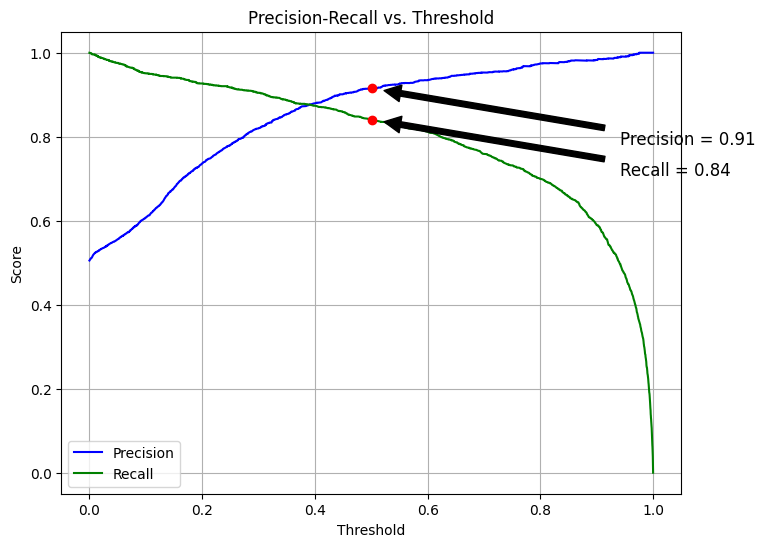

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# 예제 데이터 생성
X, y = make_classification(n_samples=20000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 확률을 얻어서 precision-recall curve를 그립니다
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Average Precision 계산
average_precision = average_precision_score(y_test, y_scores)
print(f'Average Precision: {average_precision:.2f}')

# Precision-Recall curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc='best')
plt.grid(True)

# Threshold가 0.5인 지점 표시
idx_05 = np.argmin(np.abs(thresholds - 0.5))  # Threshold가 0.5에 가장 가까운 인덱스 찾기
plt.plot(thresholds[idx_05], precision[idx_05], 'ro')  # Precision의 값을 빨간색 점으로 표시
plt.plot(thresholds[idx_05], recall[idx_05], 'ro')  # Recall의 값을 빨간색 점으로 표시

# Precision, Recall 값 표기
plt.annotate(f'Recall = {recall[idx_05]:.2f}',
             xy=(thresholds[idx_05], recall[idx_05]),
             xytext=(recall[idx_05] + 0.1, recall[idx_05] - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12,
             horizontalalignment='left',
             verticalalignment='top')
plt.annotate(f'Precision = {precision[idx_05]:.2f}',
             xy=(thresholds[idx_05], precision[idx_05]),
             xytext=(recall[idx_05] + 0.1, precision[idx_05] - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12,
             horizontalalignment='left',
             verticalalignment='top')

plt.show()
